In [6]:
import numpy as np
import pandas as pd
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import itertools 
import matplotlib
from utils import get_best_configuration, calculate_cost, get_result_from_data, get_best_configuration_from_defaults, calculate_cpu_mem_costs

## Settings
This block defines the settings such as the search space configurations and input parameters to the rest of the notebook

In [7]:
CPU_LIMITS= [ '250m', '500m', '750m', '1000m', '1250m', '1500m', '1750m', '2000m' ]
MEMORY_LIMITS=[ '128Mi', '256Mi', '512Mi', '768Mi', '1024Mi', '2048Mi' ]
instance_types = ['m5', 'm5a', 'c5', 'c5a', 'c6g', 'm6g']
benchmarks = {"transcode": "cats-1", "pigo-faceblur": "faces2", "pigo-face-detector": "faces2", "openfaas-ocr": "doc", "linpack": "2500", "s3": "cats-1"}

# DEFAULT_CPU_LIMITS = [ '167m', '333m',  '500m', '667m', '833m', '1000m', '1167m', '1333m', '1500m', '1667m', '1833m', '2000m' ]
# DEFAULT_MEMORY_LIMITS=[ '256Mi', '512Mi', '768Mi', '1024Mi', '1280Mi', '1536Mi', '1792Mi', '2048Mi', '2304Mi', '2560Mi', '2816Mi', '3072Mi']

# The CPU and Memory options that approximate the resource allocation in AWS lambda based on the proportional cpu allocation based on memory
DEFAULT_CPU_LIMITS = [ '250m', '500m', '750m', '1000m', '1250m', '1500m', '1750m', '2000m' ]
DEFAULT_MEMORY_LIMITS = ['426Mi', '853Mi', '1279Mi', '1706Mi', '2132Mi', '2559Mi', '2985Mi', '3412Mi']

# An Azure-like strategy that charges for only the consumed memory, we find the consumed memory to the nearest 128MB block and use that
A_MEM = {"transcode": "256Mi", "pigo-faceblur": "128Mi", "pigo-face-detector": "128Mi", "openfaas-ocr": "256Mi", "linpack": "512Mi", "s3": "128Mi"}

benchmark_naming = {"transcode": "transcode", "pigo-faceblur": "faceblur", "pigo-face-detector": "facedetect", "openfaas-ocr": "ocr", "linpack": "linpack", "s3": "s3"}

data_dir = 'analysis_data/'

calculate_cpu_mem_costs()

## For Execution time

In [8]:
dataframe = pd.DataFrame(columns = ['Norm. best ET', 'search space', 'benchmark'])
for benchmark in benchmarks.keys():
    confs = zip(DEFAULT_CPU_LIMITS, DEFAULT_MEMORY_LIMITS)
    data_name = benchmarks[benchmark]
    print(benchmark)
    best_runtime = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, benchmark, data_name)
    print(best_runtime)
    best_runtime_m5_1 = get_best_configuration(['m5'], CPU_LIMITS, MEMORY_LIMITS, benchmark, data_name)
    best_runtime_m5_2 = get_best_configuration(['m5'], DEFAULT_CPU_LIMITS, DEFAULT_MEMORY_LIMITS, benchmark, data_name)
    print(best_runtime_m5_1, best_runtime_m5_2)
    best_runtime_m5 = best_runtime_m5_1 if best_runtime_m5_1[0] <= best_runtime_m5_2[0] else best_runtime_m5_2
    print(best_runtime_m5)
    best_runtime_default = get_best_configuration_from_defaults(confs, benchmark, data_name)
    print(best_runtime_default)
    config = {"instance_type": 'm5', "memory": "1706", "cpu": "1000"}
    best_runtime_azure = get_result_from_data(benchmark, data_name, config, MEMORY_LIMITS=None, metric='runtime')
    print(best_runtime_azure)

    dataframe = dataframe.append({'Norm. best ET': best_runtime[0]/best_runtime[0], 'search space': 'Decoupled', 'benchmark': benchmark_naming[benchmark]}, ignore_index=True)
    dataframe = dataframe.append({'Norm. best ET': best_runtime_m5[0]/best_runtime[0], 'search space': 'Decoupled (m5)', 'benchmark': benchmark_naming[benchmark]}, ignore_index=True)
    dataframe = dataframe.append({'Norm. best ET': best_runtime_default[0]/best_runtime[0], 'search space': 'Prop. CPU', 'benchmark': benchmark_naming[benchmark]}, ignore_index=True)
    dataframe = dataframe.append({'Norm. best ET': best_runtime_azure/best_runtime[0], 'search space': 'Fixed CPU', 'benchmark': benchmark_naming[benchmark]}, ignore_index=True)


dataframe.to_csv(data_dir + 'et-decoupled-default.csv', index=False)

transcode
(41.0473, '1024Mi', 'c5a_2000m')
(58.5186, '2048Mi', 'm5_2000m') (59.0511, '3412Mi', 'm5_2000m')
(58.5186, '2048Mi', 'm5_2000m')
(59.0511, '3412Mi', 'm5_2000m')
112.2006
pigo-faceblur
(4.43025, '768Mi', 'c5_1000m')
(4.7363, '512Mi', 'm5_2000m') (4.62395, '3412Mi', 'm5_2000m')
(4.62395, '3412Mi', 'm5_2000m')
(4.62395, '3412Mi', 'm5_2000m')
4.9656
pigo-face-detector
(4.08395, '2048Mi', 'c5_1000m')
(4.453250000000001, '768Mi', 'm5_2000m') (4.2483, '3412Mi', 'm5_2000m')
(4.2483, '3412Mi', 'm5_2000m')
(4.2483, '3412Mi', 'm5_2000m')
4.644399999999999
openfaas-ocr
(9.9643, '512Mi', 'c5_2000m')
(10.7529, '1024Mi', 'm5_2000m') (10.73885, '3412Mi', 'm5_2000m')
(10.73885, '3412Mi', 'm5_2000m')
(10.73885, '3412Mi', 'm5_2000m')
21.488149999999997
linpack
(3.4084880352020264, '512Mi', 'c5a_2000m')
(3.727247476577759, '768Mi', 'm5_2000m') (3.766754150390625, '3412Mi', 'm5_2000m')
(3.727247476577759, '768Mi', 'm5_2000m')
(3.766754150390625, '3412Mi', 'm5_2000m')
3.768745422363281
s3
(2.16910

## For Execution Cost

In [9]:
ec_dataframe = pd.DataFrame(columns = ['Norm. best EC', 'search space', 'benchmark'])
for benchmark in benchmarks.keys():
    confs = zip(DEFAULT_CPU_LIMITS, DEFAULT_MEMORY_LIMITS)
    data_name = benchmarks[benchmark]
    print(benchmark)
    best_cost = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, benchmark, data_name, metric='cost')
    print(best_cost)
    best_cost_m5_1 = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, benchmark, data_name, metric='cost')
    best_cost_m5_2 = get_best_configuration(['m5'], DEFAULT_CPU_LIMITS, DEFAULT_MEMORY_LIMITS, benchmark, data_name, metric='cost')
    print(best_cost_m5_1, best_cost_m5_2)
    best_cost_m5 = best_cost_m5_1 if best_cost_m5_1[0] <= best_cost_m5_2[0] else best_cost_m5_2
    print(best_cost_m5)
    best_cost_default = get_best_configuration_from_defaults(confs, benchmark, data_name, metric='cost')
    print(best_cost_default)

    config = {"instance_type": 'm5', "memory": "1706", "cpu": "1000"}
    best_runtime_azure = get_result_from_data(benchmark, data_name, config, MEMORY_LIMITS=None, metric='runtime')
    # print(best_runtime_azure)
    azure_cost = calculate_cost("1000", A_MEM[benchmark], best_runtime_azure, "m5")
    print(azure_cost)

    ec_dataframe = ec_dataframe.append({'Norm. best EC': best_cost[0]/best_cost[0], 'search space': 'Decoupled', 'benchmark': benchmark_naming[benchmark]}, ignore_index=True)
    ec_dataframe = ec_dataframe.append({'Norm. best EC': best_cost_m5[0]/best_cost[0], 'search space': 'Decoupled (m5)', 'benchmark': benchmark_naming[benchmark]}, ignore_index=True)
    ec_dataframe = ec_dataframe.append({'Norm. best EC': best_cost_default[0]/best_cost[0], 'search space': 'Prop. CPU', 'benchmark': benchmark_naming[benchmark]}, ignore_index=True)
    ec_dataframe = ec_dataframe.append({'Norm. best EC': azure_cost/best_cost[0], 'search space': 'Fixed CPU', 'benchmark': benchmark_naming[benchmark]}, ignore_index=True)

ec_dataframe.to_csv(data_dir + 'ec-decoupled-default.csv', index=False)

transcode
(0.0006927447916666666, '512Mi', 'm6g_2000m')
(0.0006927447916666666, '512Mi', 'm6g_2000m') (0.001066016829630534, '426Mi', 'm5_250m')
(0.0006927447916666666, '512Mi', 'm6g_2000m')
(0.001066016829630534, '426Mi', 'm5_250m')
0.00105772440625
pigo-faceblur
(4.012685763888889e-05, '256Mi', 'c5a_500m')
(4.012685763888889e-05, '256Mi', 'c5a_500m') (4.538448565673828e-05, '426Mi', 'm5_750m')
(4.012685763888889e-05, '256Mi', 'c5a_500m')
(4.836100010172526e-05, '426Mi', 'm5_250m')
4.61645625e-05
pigo-face-detector
(3.545851822916666e-05, '512Mi', 'm6g_1000m')
(3.545851822916666e-05, '512Mi', 'm6g_1000m') (4.270268676757812e-05, '426Mi', 'm5_750m')
(3.545851822916666e-05, '512Mi', 'm6g_1000m')
(4.70358246866862e-05, '426Mi', 'm5_250m')
4.317840624999999e-05
openfaas-ocr
(0.00015202547499999997, '256Mi', 'm6g_2000m')
(0.00015202547499999997, '256Mi', 'm6g_2000m') (0.0002341520247802734, '3412Mi', 'm5_2000m')
(0.00015202547499999997, '256Mi', 'm6g_2000m')
(0.0002341520247802734, '3412Mi

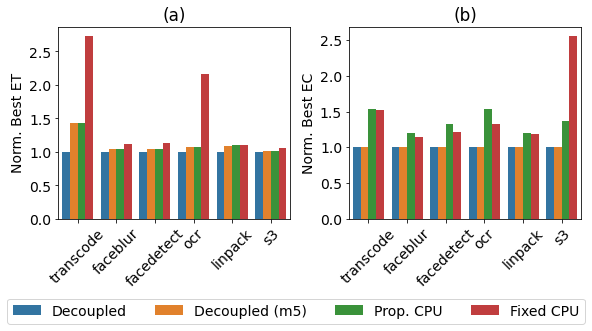

In [10]:
matplotlib.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(figsize=(8, 4), ncols=2, constrained_layout=True)
# matplotlib.rcParams.update({'font.size': 16})

dataframe = pd.read_csv(data_dir + 'et-decoupled-default.csv')
ec_dataframe = pd.read_csv(data_dir + 'ec-decoupled-default.csv')

dataframe.replace(benchmark_naming, inplace=True)
ec_dataframe.replace(benchmark_naming, inplace=True)

ax1 = sns.barplot(data=dataframe, x='benchmark', y='Norm. best ET', hue='search space', ax=axs[0])
ax1.legend().set_visible(False)
ax1.tick_params(axis='x', labelrotation=45)

ax2 = sns.barplot(data=ec_dataframe, x='benchmark', y='Norm. best EC', hue='search space', ax=axs[1])
ax2.legend().set_visible(False)
# plt.legend(fontsize="small", bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#                 mode="expand", borderaxespad=0, ncol=2)
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0))
# plt.legend(fontsize="small", ncol=2, loc='upper center',  bbox_to_anchor=(0.5, 1.05))
ax2.tick_params(axis='x', labelrotation=45)

ax2.set_title('(b)', loc='center')
ax2.xaxis.label.set_visible(False)
ax2.set_ylabel('Norm. Best EC')
ax1.set_title('(a)', loc='center')
ax1.xaxis.label.set_visible(False)
ax1.set_ylabel('Norm. Best ET')

plt.savefig('decoupled-default.pdf', bbox_inches = "tight")